<a href="https://colab.research.google.com/github/incognitofox/senior_research/blob/master/timeseries_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan  7 13:06:49 2020

@author: Will
"""

import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import sys
import io
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()

all_data = pd.read_csv(io.BytesIO(uploaded['hourly.csv']))
all_data.head()
print(all_data.shape)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
'''plt.rcParams["figure.figsize"] = fig_size
plt.title('Time vs Temperature')
plt.ylabel('Total Temperature')
plt.xlabel('Time')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(all_data[column_name])'''

print(all_data.columns)
column_name = 'T_HR_AVG'
all_data = all_data[column_name].values.astype(float)
print(all_data)

test_data_size = 360

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

print(len(train_data))
print(len(test_data))
print(test_data)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

print(train_data_normalized[:5])
print(train_data_normalized[-5:])

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

train_window = 360

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

Saving hourly.csv to hourly (3).csv
(8760, 38)
Index(['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME', 'CRX_VN',
       'LONGITUDE', 'LATITUDE', 'T_CALC', 'T_HR_AVG', 'T_MAX', 'T_MIN',
       'P_CALC', 'SOLARAD', 'SOLARAD_FLAG', 'SOLARAD_MAX', 'SOLARAD_MAX_FLAG',
       'SOLARAD_MIN', 'SOLARAD_MIN_FLAG', 'SUR_TEMP_TYPE', 'SUR_TEMP',
       'SUR_TEMP_FLAG', 'SUR_TEMP_MAX', 'SUR_TEMP_MAX_FLAG', 'SUR_TEMP_MIN',
       'SUR_TEMP_MIN_FLAG', 'RH_HR_AVG', 'RH_HR_AVG_FLAG', 'SOIL_MOISTURE_5',
       'SOIL_MOISTURE_10', 'SOIL_MOISTURE_20', 'SOIL_MOISTURE_50',
       'SOIL_MOISTURE_100', 'SOIL_TEMP_5', 'SOIL_TEMP_10', 'SOIL_TEMP_20',
       'SOIL_TEMP_50', 'SOIL_TEMP_100'],
      dtype='object')
[ -8.6  -9.9 -10.7 ...   5.4   5.6   5.9]
8400
360
[ 5.5  5.6  5.8  6.8  7.3  6.8  7.   6.9  6.5  6.1  5.1  5.3  5.5  5.4
  6.7  7.9  7.9  9.7 11.5 11.9 12.  12.1 10.3  9.1  8.7  7.4  6.4  5.5
  4.8  4.6  4.1  3.2  2.6  2.   1.4  0.8  0.5  1.   2.2  3.6  4.9  6.5
  7.4  7.7  7.7  7.1  6.1  4.8  

In [5]:
dev=torch.device("cuda:0")
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [0]:
model = LSTM()#.to(dev)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

epochs = 100

for i in range(epochs):
    count = 0;
    for seq, labels in train_inout_seq:
        print(count)
        count+=1
        seq_temp = seq.to(dev)
        labels_temp = labels.to(dev)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if single_loss.item() <= 0.000001:
        break
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')


LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204


In [0]:
fut_pred = 360

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

test_inputs[fut_pred:]

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
#print(actual_predictions)
print("reached")
print(actual_predictions.shape)

[-0.5886287689208984, -0.6187291145324707, -0.6321070194244385, -0.648829460144043, -0.6588628888130188, -0.6755852699279785, -0.6822742223739624, -0.6889632344245911, -0.6688963174819946, -0.5652173757553101, -0.46822741627693176, -0.3913043439388275, -0.33110368251800537, -0.284280925989151, -0.26421403884887695, -0.260869562625885, -0.28762543201446533, -0.3745819330215454, -0.4381271004676819, -0.47826087474823, -0.5150501728057861, -0.5484949946403503, -0.571906328201294, -0.5919732451438904, -0.6020066738128662, -0.6321070194244385, -0.6454849243164062, -0.6588628888130188, -0.6722407937049866, -0.6856187582015991, -0.695652186870575, -0.695652186870575, -0.6789297461509705, -0.5785953402519226, -0.4816053509712219, -0.4046822786331177, -0.3411371111869812, -0.29765886068344116, -0.27424749732017517, -0.2709030210971832, -0.3010033369064331, -0.3812709152698517, -0.4481605291366577, -0.4816053509712219, -0.52173912525177, -0.5518394708633423, -0.5752508640289307, -0.5986621975898

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

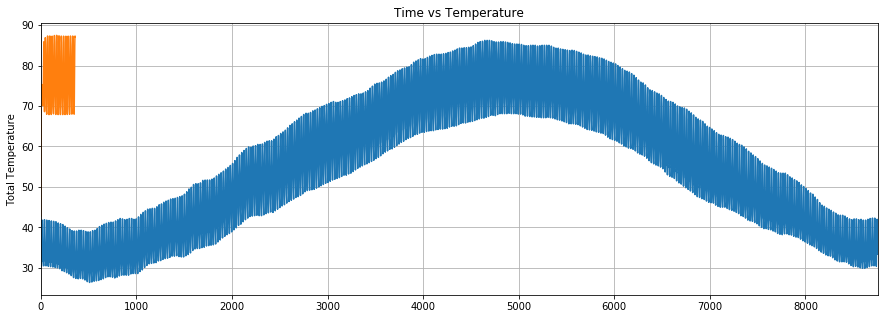

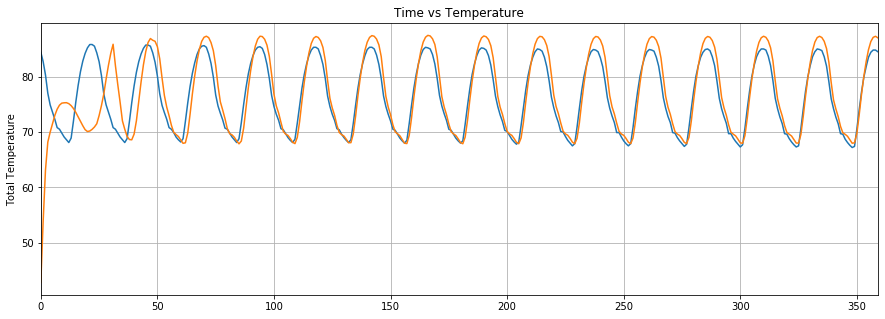

In [0]:
x = np.arange(0, 360, 1)
print(x)
print(x.shape)
print(actual_predictions.shape)
plt.title('Time vs Temperature')
plt.ylabel('Total Temperature')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(all_data)
plt.plot(x,actual_predictions)
plt.show()

plt.title('Time vs Temperature')
plt.ylabel('Total Temperature')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(all_data[4840:5200])
plt.plot(x,actual_predictions)
plt.show()